# Regressão Logística I
## Tarefa II

Vamos trabalhar com a mesma base do exercício anterior, mas vamos aprofundar um pouco mais a nossa regressão.

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import script

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.metrics import roc_curve
from sklearn import metrics

from scipy.stats import ks_2samp

In [2]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'

df = pd.read_csv(url, 
                 names=['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num'])
df['flag_doente'] = (df['num']!=0).astype('int64')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


In [3]:
df['flag_doente'] = ((df['num'] != 0).astype('int64'))

df['sex'] = df['sex'].replace({0: 'Feminino', 1: 'Masculino'})

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente
0,63.0,Masculino,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,Masculino,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,Masculino,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,Masculino,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,Feminino,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


A descrição das variáveis está recortada abaixo:
- age: idade do paciente em anos
- sex: sexo (1 = male; 0 = female)  
- cp: tipo de dor no peito
  - 1: angina típica
  - 2: angina atípica
  - 3: dor não-angina
  - 4: assintomático
- trestbps: pressão sanguínea em repouso (em mm Hg na admissão ao hospital
- chol: colesterol sérico em mg/dl
- fbs: (açúcar no sangue em jejum > 120 mg/dl) (1 = True; 0 = False)
- restecg: resultados eletrocardiográficos em repouso
  - 0: normal
  - 1: tendo anormalidade da onda ST-T (Inversões de onda T e / ou ST com elevação ou depressão de > 0.05 mV)
  - 2: mostrando hipertrofia ventricular esquerda provável ou definitiva pelos critérios de Estes
- thalach: frequência cardíaca máxima alcançada
- exang: angina induzida por exercício(1 = sim; 0 = não)
- oldpeak = Depressão de ST induzida por exercício em relação ao repouso
- slope: Depressão de ST induzida por exercício em relação ao repouso
  - 1: inclinação ascendente
  - 2: estável
  - 3: inclinação descendente
- ca: número de vasos principais (0-3) coloridos por fluorosopia
- thal: 3 = normal; 6 = defeito corrigido; 7 = defeito reversível
- num: diagnóstico de doença cardíaga (status de doença angiográfica)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          303 non-null    float64
 1   sex          303 non-null    object 
 2   cp           303 non-null    float64
 3   trestbps     303 non-null    float64
 4   chol         303 non-null    float64
 5   fbs          303 non-null    float64
 6   restecg      303 non-null    float64
 7   thalach      303 non-null    float64
 8   exang        303 non-null    float64
 9   oldpeak      303 non-null    float64
 10  slope        303 non-null    float64
 11  ca           303 non-null    object 
 12  thal         303 non-null    object 
 13  num          303 non-null    int64  
 14  flag_doente  303 non-null    int64  
dtypes: float64(10), int64(2), object(3)
memory usage: 35.6+ KB


In [5]:
Qualitativas = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
Quantitativas = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

1. Considere o script que monta a análise bivariada que você fez na tarefa anterior. Transforme esse script em uma função, que deve:
- Ter como parâmetros de entrada:
    - Um *dataframe* contendo os dados a serem avaliados
    - Um *string* contendo o nome da variável resposta
    - Um *string* contendo o nome da variável explicativa
- E deve retornar um *dataframe* com os dados da bivariada. 
**Monte** a mesma bivariada pelo menos três variáveis qualitativas do *data-frame*. Qual delas parece discriminar mais o risco?

In [6]:
tab_sex = script.Qualitativa(df, 'flag_doente', 'sex')
tab_sex

flag_doente,Saudavel,Doente,Total,Media_doentes,Odds_Doentes,RC_vs_total_OddsRatio,Logito,WOE
sex,,,,,,,,
Feminino,72,25,97,0.257732,0.347222,0.409672,-1.057790,-0.892398
Masculino,92,114,206,0.553398,1.239130,1.461996,0.214410,0.379802
Total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [7]:
tab_cp = script.Qualitativa(df, 'flag_doente', 'cp')
tab_cp

flag_doente,Saudavel,Doente,Total,Media_doentes,Odds_Doentes,RC_vs_total_OddsRatio,Logito,WOE
cp,,,,,,,,
1.0,16,7,23,0.304348,0.437500,0.516187,-0.826679,-0.661286
2.0,41,9,50,0.180000,0.219512,0.258993,-1.516347,-1.350955
3.0,68,18,86,0.209302,0.264706,0.312315,-1.329136,-1.163743
4.0,39,105,144,0.729167,2.692308,3.176536,0.990399,1.155791
Total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [8]:
tab_fbs = script.Qualitativa(df, 'flag_doente', 'fbs')
tab_fbs

flag_doente,Saudavel,Doente,Total,Media_doentes,Odds_Doentes,RC_vs_total_OddsRatio,Logito,WOE
fbs,,,,,,,,
0.0,141,117,258,0.453488,0.829787,0.979030,-0.186586,-0.021193
1.0,23,22,45,0.488889,0.956522,1.128558,-0.044452,0.120941
Total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [9]:
tab_restecg = script.Qualitativa(df, 'flag_doente', 'restecg')
tab_restecg

flag_doente,Saudavel,Doente,Total,Media_doentes,Odds_Doentes,RC_vs_total_OddsRatio,Logito,WOE
restecg,,,,,,,,
0.0,95,56,151,0.370861,0.589474,0.695494,-0.528525,-0.363133
1.0,1,3,4,0.750000,3.000000,3.539568,1.098612,1.264005
2.0,68,80,148,0.540541,1.176471,1.388066,0.162519,0.327911
Total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [10]:
tab_exang = script.Qualitativa(df, 'flag_doente', 'exang')
tab_exang

flag_doente,Saudavel,Doente,Total,Media_doentes,Odds_Doentes,RC_vs_total_OddsRatio,Logito,WOE
exang,,,,,,,,
0.0,141,63,204,0.308824,0.446809,0.527170,-0.805625,-0.640233
1.0,23,76,99,0.767677,3.304348,3.898655,1.195239,1.360632
Total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [11]:
tab_slope = script.Qualitativa(df, 'flag_doente', 'slope')
tab_slope

flag_doente,Saudavel,Doente,Total,Media_doentes,Odds_Doentes,RC_vs_total_OddsRatio,Logito,WOE
slope,,,,,,,,
1.0,106,36,142,0.253521,0.339623,0.400706,-1.079920,-0.914528
2.0,49,91,140,0.650000,1.857143,2.191161,0.619039,0.784432
3.0,9,12,21,0.571429,1.333333,1.573141,0.287682,0.453075
Total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [12]:
tab_ca = script.Qualitativa(df, 'flag_doente', 'ca')
tab_ca

flag_doente,Saudavel,Doente,Total,Media_doentes,Odds_Doentes,RC_vs_total_OddsRatio,Logito,WOE
ca,,,,,,,,
0.0,130,46,176,0.261364,0.353846,0.417488,-1.038893,-0.873501
1.0,21,44,65,0.676923,2.095238,2.472079,0.739667,0.905060
2.0,7,31,38,0.815789,4.428571,5.225077,1.488077,1.653470
3.0,3,17,20,0.850000,5.666667,6.685851,1.734601,1.899994
?,3,1,4,0.250000,0.333333,0.393285,-1.098612,-0.933220
Total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


In [13]:
tab_thal = script.Qualitativa(df, 'flag_doente', 'thal')
tab_thal

flag_doente,Saudavel,Doente,Total,Media_doentes,Odds_Doentes,RC_vs_total_OddsRatio,Logito,WOE
thal,,,,,,,,
3.0,129,37,166,0.222892,0.286822,0.338408,-1.248894,-1.083502
6.0,6,12,18,0.666667,2.000000,2.359712,0.693147,0.858540
7.0,28,89,117,0.760684,3.178571,3.750257,1.156432,1.321824
?,1,1,2,0.500000,1.000000,1.179856,0.000000,0.165392
Total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000


2. Monte uma função semelhante para categorizar variáveis quantitativas contínuas (com muitas categorias) como ```age```.  
    Além dos mesmos parâmetros da função anterior, defina mais um parâmetro como número de categorias que você deseja quebrar. Defina um valor '*default*' de 5 grupos para este parâmetro.  

In [14]:
tab_age = script.Quantitativa(df, 'flag_doente', 'age')
tab_age

flag_doente,Saudavel,Doente,Total,Media_doentes,Odds_Doentes,RC_vs_total_OddsRatio,Logito,WOE,Media_age
age,,,,,,,,,
"(28.999, 45.0]",47,16,63,0.253968,0.340426,0.401653,-1.077559,-0.912166,41.222222
"(45.0, 53.0]",42,22,64,0.343750,0.523810,0.618020,-0.646627,-0.481235,50.000000
"(53.0, 58.0]",32,39,71,0.549296,1.218750,1.437950,0.197826,0.363218,56.211268
"(58.0, 62.0]",13,32,45,0.711111,2.461538,2.904261,0.900787,1.066179,60.355556
"(62.0, 77.0]",30,30,60,0.500000,1.000000,1.179856,0.000000,0.165392,66.516667
Total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000,54.861142


In [15]:
tab_trestbps = script.Quantitativa(df, 'flag_doente', 'trestbps')
tab_trestbps

flag_doente,Saudavel,Doente,Total,Media_doentes,Odds_Doentes,RC_vs_total_OddsRatio,Logito,WOE,Media_trestbps
trestbps,,,,,,,,,
"(93.999, 120.0]",60,37,97,0.381443,0.616667,0.727578,-0.483427,-0.318034,113.463918
"(120.0, 126.0]",10,15,25,0.600000,1.500000,1.769784,0.405465,0.570858,124.320000
"(126.0, 134.0]",35,27,62,0.435484,0.771429,0.910175,-0.259511,-0.094119,130.177419
"(134.0, 144.6]",34,24,58,0.413793,0.705882,0.832840,-0.348307,-0.182914,139.103448
"(144.6, 200.0]",25,36,61,0.590164,1.440000,1.698993,0.364643,0.530036,158.180328
Total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000,133.049023


In [16]:
tab_chol = script.Quantitativa(df, 'flag_doente', 'chol')
tab_chol

flag_doente,Saudavel,Doente,Total,Media_doentes,Odds_Doentes,RC_vs_total_OddsRatio,Logito,WOE,Media_chol
chol,,,,,,,,,
"(125.999, 204.0]",37,25,62,0.403226,0.675676,0.797200,-0.392042,-0.226650,184.451613
"(204.0, 230.0]",36,24,60,0.400000,0.666667,0.786571,-0.405465,-0.240073,217.916667
"(230.0, 254.0]",36,26,62,0.419355,0.722222,0.852118,-0.325422,-0.160030,241.919355
"(254.0, 286.0]",27,32,59,0.542373,1.185185,1.398348,0.169899,0.335292,269.288136
"(286.0, 564.0]",28,32,60,0.533333,1.142857,1.348407,0.133531,0.298924,322.500000
Total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000,247.215154


In [17]:
tab_thalach = script.Quantitativa(df, 'flag_doente', 'thalach')
tab_thalach

flag_doente,Saudavel,Doente,Total,Media_doentes,Odds_Doentes,RC_vs_total_OddsRatio,Logito,WOE,Media_thalach
thalach,,,,,,,,,
"(70.999, 130.0]",16,47,63,0.746032,2.937500,3.465827,1.077559,1.242951,114.904762
"(130.0, 146.0]",20,39,59,0.661017,1.950000,2.300719,0.667829,0.833222,139.610169
"(146.0, 159.0]",39,23,62,0.370968,0.589744,0.695813,-0.528067,-0.362675,153.241935
"(159.0, 170.0]",41,21,62,0.338710,0.512195,0.604317,-0.669050,-0.503657,164.145161
"(170.0, 202.0]",48,9,57,0.157895,0.187500,0.221223,-1.673976,-1.508584,178.543860
Total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000,150.089178


In [18]:
tab_oldpeak = script.Quantitativa(df,'flag_doente', 'oldpeak')
tab_oldpeak

flag_doente,Saudavel,Doente,Total,Media_doentes,Odds_Doentes,RC_vs_total_OddsRatio,Logito,WOE,Media_oldpeak
oldpeak,,,,,,,,,
"(-0.001, 0.38]",88,33,121,0.272727,0.375000,0.442446,-0.980829,-0.815437,0.033058
"(0.38, 1.12]",37,24,61,0.393443,0.648649,0.765312,-0.432864,-0.267472,0.729508
"(1.12, 1.9]",30,32,62,0.516129,1.066667,1.258513,0.064539,0.229931,1.491935
"(1.9, 6.2]",9,50,59,0.847458,5.555556,6.554756,1.714798,1.880191,2.949153
Total,164,139,303,0.458746,0.847561,1.000000,-0.165392,0.000000,1.300914


3. Construa um modelo de regressão logística com as variáveis qualitativas: ```sex + cp +  trestbps``` e com a variável quantitativa ```age```.

**Interprete os parâmetros.**

In [19]:
reglog = smf.logit(formula="flag_doente ~ sex + cp + trestbps + age",
                   data=df).fit()
reglog.summary()

Optimization terminated successfully.
         Current function value: 0.510076
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      298
Method:                           MLE   Df Model:                            4
Date:                Wed, 09 Aug 2023   Pseudo R-squ.:                  0.2605
Time:                        18:42:49   Log-Likelihood:                -154.55
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 1.264e-22
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -11.1167      1.608     -6.915      0.000     -14.267      -7.966
sex[T.Masculino]     1.8021      0.331      5.444      0.000       1.153       2.451
cp                   1.1403      0.169      6.739      0.000       0.809       1.472
trestbps             0.0214      0.008      2.600      0.009       0.005       0.037
age                  0.0582      0.017      3.348      0.001       0.024       0.092
====================================================================================
"""

4. Avalie o seu modelo quanto a **calibragem**:
- Calcule a probabilidade de evento predita segundo o seu modelo
- Categorize essa probabilidade em G=5 grupos
- Calcule a probabilidade de evento predita média por grupo
- Calcule a taxa de eventos (média da variável indicadora de eventos) por grupo
- Compare graficamente o valor operado versus observado para a taxa de maus por grupo

In [20]:
df['Predito'] = reglog.predict(df)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,flag_doente,Predito
0,63.0,Masculino,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0,0.196041
1,67.0,Masculino,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1,0.928431
2,67.0,Masculino,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1,0.846558
3,37.0,Masculino,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0,0.276207
4,41.0,Feminino,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0,0.024768


In [21]:
cat_pred = pd.qcut(x=df['Predito'],
                   q=5,
                   duplicates='drop')
group_reg = df.groupby(by=cat_pred)
qualid = group_reg[['flag_doente']].count().rename(columns={'flag_doente': 'Contagem'})
qualid['Predito'] = group_reg['Predito'].mean()
qualid['Pct_doente'] = group_reg['flag_doente'].mean()
qualid

,Contagem,Predito,Pct_doente
Predito,,,
"(0.0119, 0.146]",61,0.076255,0.098361
"(0.146, 0.349]",60,0.249060,0.183333
"(0.349, 0.575]",61,0.457982,0.491803
"(0.575, 0.772]",60,0.673059,0.683333
"(0.772, 0.928]",61,0.837449,0.836066


Text(0.5, 0, 'Grupo')

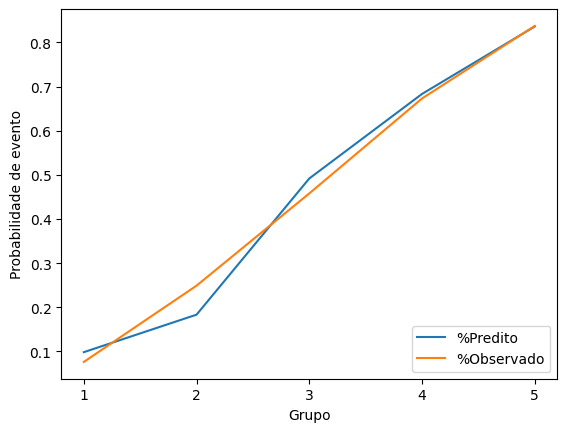

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax = qualid['Pct_doente'].plot(label='%Predito')
ax = qualid['Predito'].plot(label='%Observado')

ticks = ax.set_xticks([0, 1, 2, 3, 4])
labels = ax.set_xticklabels([1, 2, 3, 4, 5])
ax.legend(loc="lower right")
ax.set_ylabel('Probabilidade de evento')
ax.set_xlabel('Grupo')

5. Avalie o seu modelo quanto a discriminação calculando acurácia, GINI e KS.

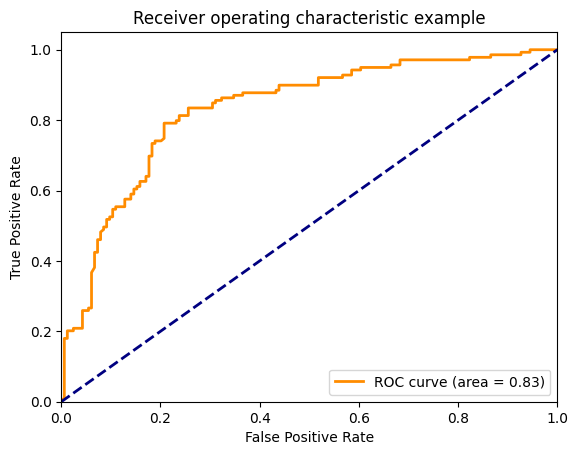

In [23]:
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['Predito'])

plt.figure()
lw = 2

fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['Predito'])
auc_ = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc_)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

Text(0, 0.5, 'Função Distribuição Acumulada')

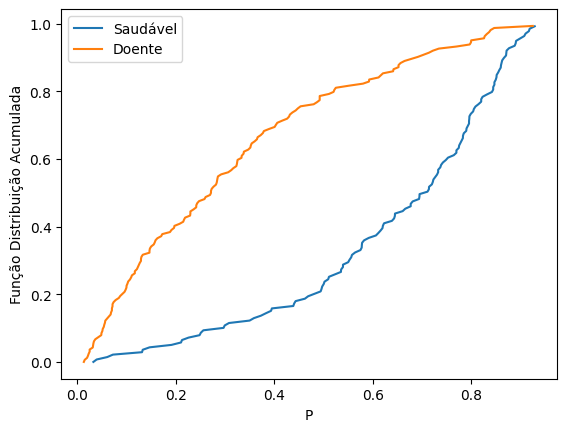

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

score_pop1 = df.loc[df['flag_doente']==1,'Predito']
ax.plot(np.sort(score_pop1), np.linspace(0, 1, len(score_pop1), endpoint=False), label='Saudável')

score_pop2 = df.loc[df['flag_doente']!=1,'Predito']
ax.plot(np.sort(score_pop2), np.linspace(0, 1, len(score_pop2), endpoint=False), label='Doente')
ax.legend()

ax.set_xlabel('P')
ax.set_ylabel('Função Distribuição Acumulada')

In [25]:
acc = metrics.accuracy_score(df['flag_doente'], df['Predito']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['Predito'])
auc_ = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc_ -1
#KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'Predito'], df.loc[df['flag_doente'] != 1, 'Predito']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 77.89%
KS: 58.40% 
AUC: 83.11% 
GINI: 66.22%


6. tente melhorar o modelo obtido, por exemplo inserindo ou removendo variáveis.  
    Avalie as características do seu modelo (calibragem e acurácia).

In [26]:
reglog_melhorado = smf.logit(formula="flag_doente ~ sex + cp + trestbps + exang + slope + ca",
                             data=df).fit()
reglog_melhorado.summary()

Optimization terminated successfully.
         Current function value: 0.376898
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            flag_doente   No. Observations:                  303
Model:                          Logit   Df Residuals:                      293
Method:                           MLE   Df Model:                            9
Date:                Wed, 09 Aug 2023   Pseudo R-squ.:                  0.4536
Time:                        18:42:50   Log-Likelihood:                -114.20
converged:                       True   LL-Null:                       -208.99
Covariance Type:            nonrobust   LLR p-value:                 5.034e-36
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -10.9691      1.795     -6.110      0.000     -14.488      -7.451
sex[T.Masculino]     1.7401      0.393      4.422      0.000       0.969       2.511
ca[T.1.0]            1.9868      0.420      4.725      0.000       1.163       2.811
ca[T.2.0]            3.0967      0.627      4.939      0.000       1.868       4.326
ca[T.3.0]            2.3312      0.722      3.230      0.001       0.916       3.746
ca[T.?]             -0.5331      1.496     -0.356      0.722      -3.464       2.398
cp                   0.8460      0.191      4.428      0.000       0.472       1.220
trestbps             0.0274      0.010      2.799      0.005       0.008       0.047
exang                1.3242      0.384      3.449      0.001       0.572       2.077
slope                1.1829      0.284      4.172      0.000       0.627       1.739
====================================================================================
"""

In [27]:
df['Predito_melhorado'] = reglog_melhorado.predict(df)

acc = metrics.accuracy_score(df['flag_doente'], df['Predito_melhorado']>.5)
print('Acurácia: {0:.2f}%'.format(acc*100))

#AUC
fpr, tpr, thresholds = metrics.roc_curve(df['flag_doente'], df['Predito_melhorado'])
auc_ = metrics.auc(fpr, tpr)
#Gini
gini = 2*auc_ -1
#KS
ks = ks_2samp(df.loc[df['flag_doente'] == 1, 'Predito_melhorado'], df.loc[df['flag_doente'] != 1, 'Predito_melhorado']).statistic

print('KS: {0:.2f}% \nAUC: {1:.2f}% \nGINI: {2:.2f}%'
      .format(ks*100, auc_*100, gini*100))

Acurácia: 82.18%
KS: 66.65% 
AUC: 90.80% 
GINI: 81.59%
